### Training a Convolutional Neural Network
Training a convolutional neural network for checking if a posture is correct.

I followed the pytorch notebook from assignment 2 of Stanford's CS231N to achieve this goal. Three experiments were performed using an 18 layer resnet. I chose a shallow, 18 layer resnet, because the dataset size is extremely small. Results are discussed at the end.

Note: To make sure the model can analyzed properly, the people (whose images are taken) used in training and test set are separate. 

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

import numpy as np

import timeit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Loading the data

During data loading, the transforms are applied as needed for ImageNet pretrained models so models can be finetuned.

In [125]:
### Data Loading

import random
import math
import os
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # Since the dataset is extremely small we can't use the below 2
        # transforms.RandomResizedCrop(224, (1,1), ratio=(1,1)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir_train = './data/train'
dataset_train = dset.ImageFolder(data_dir_train, data_transforms['train'])

data_dir_test = './data/test'
dataset_test = dset.ImageFolder(data_dir_test, data_transforms['train'])

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True) # don't maintain order
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False) # order doesn't matter

print(len(train_loader) * 8)
print(len(test_loader) * 8)

128
24


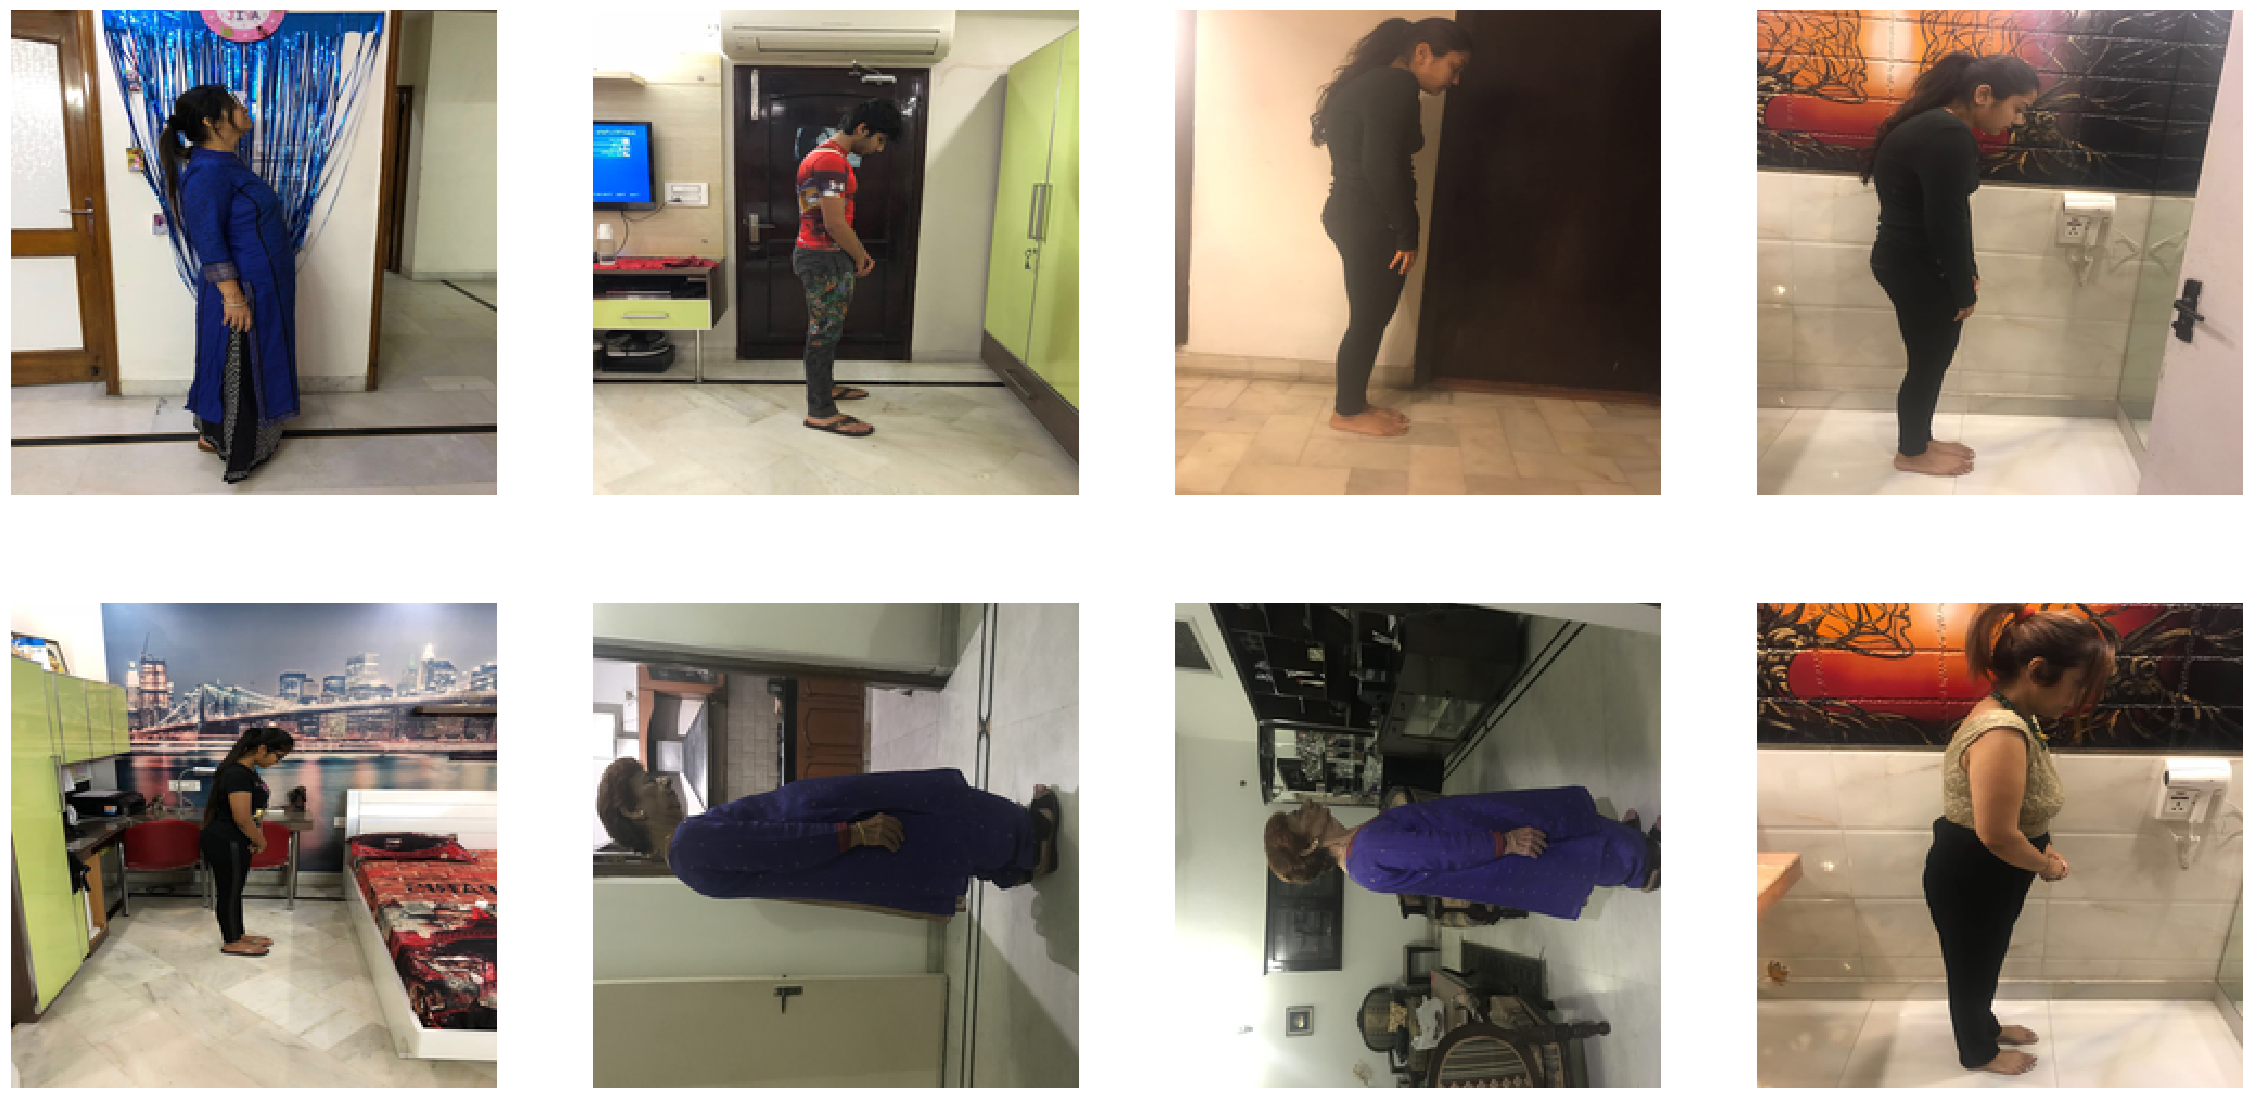

In [132]:
# Visualize some images from the dataset

def show_images(images, all_channels=False):
    """Modified version of the show_images function 
    in assignemnt 3 of CS 231n (GANs - Pytorch).
    """
    fig = plt.figure(figsize=(40, 20))
    gs = gridspec.GridSpec(2, 4)    
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if all_channels:
            if img.min() < 0:
                img /= 2
                img += 0.5
            plt.imshow(np.transpose(img.reshape([3,224,224]), (1,2,0)))
        else:
            plt.imshow(img.reshape([224,224]))
    return 

imgs = train_loader.__iter__().next()[0].view(8, 224*224*3).numpy().squeeze()
show_images(imgs, all_channels = True)

In [127]:
## Defining variables
num_classes = 2

dtype = torch.FloatTensor  # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

### Writing simple functions for training and testing

train: this function simply trains the model for 1 epoch and prints the accuracy on the training set.
test: this function tests how the model performed and prints the accuracy on the test set.

In [39]:
def train(model, loss_fn, optimizer):
    model.train(True)
    num_correct = 0
    num_samples = 0
    for t, (x, y) in enumerate(train_loader):
        x_var = Variable(x.type(dtype))
        y_var = Variable(y.type(dtype).long())
        
        #x_var = x_var[:,0,:,:].unsqueeze(1)
        y = y.long()
        scores = model(x_var)

        loss = loss_fn(scores, y_var)
        if (t + 1) % print_every == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Train: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def test(model):
    model.train(False)
    
    num_correct = 0
    num_samples = 0
    for x, y in test_loader:
        y = y.long()
        x_var = Variable(x.type(dtype))
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Val: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

### Experiment 1

Training resent-18 from scratch. A resnet model is loaded and trained for 10 epochs.

In [32]:
# Train resnet from scratch
resnet = models.resnet18(pretrained=False).type(dtype)

resnet.fc = torch.nn.Linear(512, num_classes).type(dtype) # only 2 classes

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(resnet.parameters(), lr=1e-5)

print_every = 50
for i in range(10):
    train(resnet, loss_fn, optimizer)

Train: 58 / 121 correct (47.93)
Train: 62 / 121 correct (51.24)
Train: 58 / 121 correct (47.93)
Train: 63 / 121 correct (52.07)
Train: 62 / 121 correct (51.24)
Train: 68 / 121 correct (56.20)
Train: 63 / 121 correct (52.07)
Train: 63 / 121 correct (52.07)
Train: 63 / 121 correct (52.07)
Train: 61 / 121 correct (50.41)


In [33]:
test(resnet)

Val: 8 / 20 correct (40.00)


0.4

### Experiment 2
Loading an imagenet pretrained model, and retraining the whole model on my dataset. The model is trained for 10 epochs.

In [34]:
# Use pre-trained weights but retrain whole model
resnet = models.resnet18(pretrained=True).type(dtype)

resnet.fc = torch.nn.Linear(512, num_classes).type(dtype) # only 2 classes

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(resnet.parameters(), lr=1e-6)

print_every = 50
for i in range(10):
    train(resnet, loss_fn, optimizer)

Train: 57 / 121 correct (47.11)
Train: 58 / 121 correct (47.93)
Train: 68 / 121 correct (56.20)
Train: 68 / 121 correct (56.20)
Train: 71 / 121 correct (58.68)
Train: 61 / 121 correct (50.41)
Train: 67 / 121 correct (55.37)
Train: 57 / 121 correct (47.11)
Train: 59 / 121 correct (48.76)
Train: 67 / 121 correct (55.37)


In [40]:
test(resnet)

Val: 9 / 20 correct (45.00)


0.45

### Experiment 3

Similar to the previous experiment, an ImageNet pretrained resent 18 is loaded. However, only the fully connected layer is trained so we only finetune the model.

In [37]:
# Use pre-trained weights and finetune resnet
resnet = models.resnet18(pretrained=True).type(dtype)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = torch.nn.Linear(512, num_classes).type(dtype) # only 2 classes

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-7)

print_every = 50
for i in range(10):
    train(resnet, loss_fn, optimizer)

Train: 65 / 121 correct (53.72)
Train: 64 / 121 correct (52.89)
Train: 69 / 121 correct (57.02)
Train: 67 / 121 correct (55.37)
Train: 52 / 121 correct (42.98)
Train: 61 / 121 correct (50.41)
Train: 66 / 121 correct (54.55)
Train: 60 / 121 correct (49.59)
Train: 65 / 121 correct (53.72)
Train: 64 / 121 correct (52.89)


In [38]:
test(resnet)

Val: 12 / 20 correct (60.00)


0.6

### Analysis

The dataset is extremely small, so retraining full models is very incosistent and gives accuracies between 0.4-0.6 (random). Finetuning gives a more consitent accuracy between 0.55 and 0.65. However, much more data is needed for deep learning models to be effectively trained.
